In [1]:
import pandas as pd
from transformers import BertModel, BertTokenizer
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
import torch
from torch import nn, optim
from torchmetrics import AUROC
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

# Initialization

In [2]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
data_dir = os.path.join(parent_dir, "data")

In [3]:
seed_value = 29

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = "bert-base-uncased"
"""
EMOTIONAL AXES:
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
"""
axes = ["I-E", "N-S", "T-F", "J-P"]
classes = {
    "I": 0,
    "E": 1,  # axis 1
    "N": 0,
    "S": 1,  # axis 2
    "T": 0,
    "F": 1,  # axis 3
    "J": 0,
    "P": 1,
}  # axis 4

In [6]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text.encode("ascii", "ignore").decode("ascii")
    if text.startswith("'"):
        text = text[1:-1]
    return text

In [7]:
train_n = 6624
val_n = 1024
test_n = 1024
data = pd.read_csv(os.path.join(data_dir, "mbti_1.csv"))
data = data.sample(frac=1)
labels = []
print(data.head())
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
labels = np.array(labels, dtype="float32")
train_sentences = sentences[:train_n]
y_train = labels[:train_n]
val_sentences = sentences[train_n : train_n + val_n]
y_val = labels[train_n : train_n + val_n]
test_sentences = sentences[train_n + val_n : train_n + val_n + test_n]
y_test = labels[train_n + val_n : train_n + val_n + test_n]

      type                                              posts
4698  INTP  'Personally, I'm more of dreading than fantasi...
5672  ISTJ  'Your parents love you. No matter how old you ...
6040  INTP  'My heart goes out to you.|||Once, after I had...
5381  INFJ  '(Animated Music Video) Share your favorite or...
3337  INTJ  'Marie Claire, Do you mind if I ask what you m...


In [8]:
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(
        sentences.tolist(), truncation=True, padding="max_length", max_length=seq_len
    )
    input = [
        np.array(encodings["input_ids"]),
        np.array(encodings["token_type_ids"]),
        np.array(encodings["attention_mask"]),
    ]
    return input

In [9]:
class DatasetPersonality(Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return (
            self.input_ids[idx],
            self.token_type_ids[idx],
            self.attention_mask[idx],
            self.labels[idx],
        )

In [10]:
class PersonalityDetector(LightningModule):
    def __init__(self, bert_name, n_axis, max_seq_len):
        super(PersonalityDetector, self).__init__()
        self.bert = BertModel.from_pretrained(bert_name)
        self.avgpool = nn.AvgPool1d(max_seq_len)
        self.dense = nn.Linear(self.bert.config.hidden_size, n_axis)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()
        self.auroc = AUROC(num_classes=n_axis, num_labels=n_axis, task="multilabel")

    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        last_hidden_states = outputs.last_hidden_state
        avg = (
            self.avgpool(last_hidden_states.transpose(1, 2)).transpose(1, 2).squeeze(1)
        )
        output = self.sigmoid(self.dense(avg))
        return output

    def training_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, labels = batch
        output = self(input_ids, token_type_ids, attention_mask)
        loss = self.loss(output.float(), labels.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, labels = batch
        output = self(input_ids, token_type_ids, attention_mask)
        loss = self.loss(output.float(), labels.float())
        self.log("val_loss", loss)
        self.log(
            "val_auroc",
            self.auroc(output.float(), labels.long()),
            on_step=False,
            on_epoch=True,
        )

    def test_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, labels = batch
        output = self(input_ids, token_type_ids, attention_mask)
        loss = self.loss(output.float(), labels.float())
        self.log("test_loss", loss)
        self.log(
            "test_auroc",
            self.auroc(output.float(), labels.long()),
            on_step=False,
            on_epoch=True,
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=3e-5)
        return optimizer

# Training part

In [13]:
X_train_input_ids, X_train_token_type_ids, X_train_attention_mask = prepare_bert_input(
    train_sentences, MAX_SEQ_LEN, BERT_NAME
)
X_val_input_ids, X_val_token_type_ids, X_val_attention_mask = prepare_bert_input(
    val_sentences, MAX_SEQ_LEN, BERT_NAME
)
X_test_input_ids, X_test_token_type_ids, X_test_attention_mask = prepare_bert_input(
    test_sentences, MAX_SEQ_LEN, BERT_NAME
)

In [11]:
y_train = y_train.astype(float)
y_val = y_val.astype(float)

train_dataset = DatasetPersonality(
    X_train_input_ids, X_train_token_type_ids, X_train_attention_mask, y_train
)
val_dataset = DatasetPersonality(
    X_val_input_ids, X_val_token_type_ids, X_val_attention_mask, y_val
)

train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)  # , persistent_workers=True)

In [ ]:
model = PersonalityDetector(BERT_NAME, N_AXIS, MAX_SEQ_LEN)
checkpoint_callback = ModelCheckpoint(
    monitor="val_auroc",
    mode="max",
    filename=os.path.join(data_dir, "weights-{epoch:02d}-{val_auroc:.2f}"),
    save_weights_only=True,
)
trainer = Trainer(max_epochs=7, callbacks=[checkpoint_callback], num_sanity_val_steps=0)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Kacper Kozaczko\Desktop\Stuff\PWr\II_semestr\AnalizaMediowCyfrowych\2023-projekt-amc-ziemniaki_rosomaki\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | bert    | BertModel       | 109 M 
1 | avgpool | AvgPool1d       | 0     
2 | dense   | Linear   

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Imreading model weights part

In [11]:
weights_path = os.path.join(data_dir, "weights-epoch=01-val_auroc=0.74.ckpt")

In [12]:
weights = torch.load(weights_path)

In [13]:
weights.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops'])

In [14]:
model = PersonalityDetector(BERT_NAME, N_AXIS, MAX_SEQ_LEN)
model.load_state_dict(weights["state_dict"])

<All keys matched successfully>

# Testing part

In [19]:
y_test = y_test.astype(float)
test_dataset = DatasetPersonality(
    X_test_input_ids, X_test_token_type_ids, X_test_attention_mask, y_test
)

test_dataloader = DataLoader(test_dataset, batch_size=32)

In [32]:
from tqdm.autonotebook import tqdm

model.eval()  # set the model to evaluation mode
with torch.no_grad():  # turn off gradients, since we are in test mode
    predictions = []
    for batch in tqdm(
        test_dataloader, total=len(test_dataloader), desc="Batch", colour="yellow"
    ):
        input_ids, token_type_ids, attention_mask, labels = batch
        output = model(input_ids, token_type_ids, attention_mask)
        predictions.append(output)

Batch:   0%|          | 0/32 [00:00<?, ?it/s]

In [58]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure(figsize=(20, 10))
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(
                fpr,
                tpr,
                label="ROC curve of class {0} (area = {1:0.2f})".format(
                    classes[i], roc_auc
                ),
            )
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(
            fpr, tpr, label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc)
        )
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label="ROC curve (area = {0:0.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [59]:
predictions_lists = [tensor.tolist() for tensor in predictions]

In [60]:
flattened_list = np.array([item for sublist in predictions_lists for item in sublist])

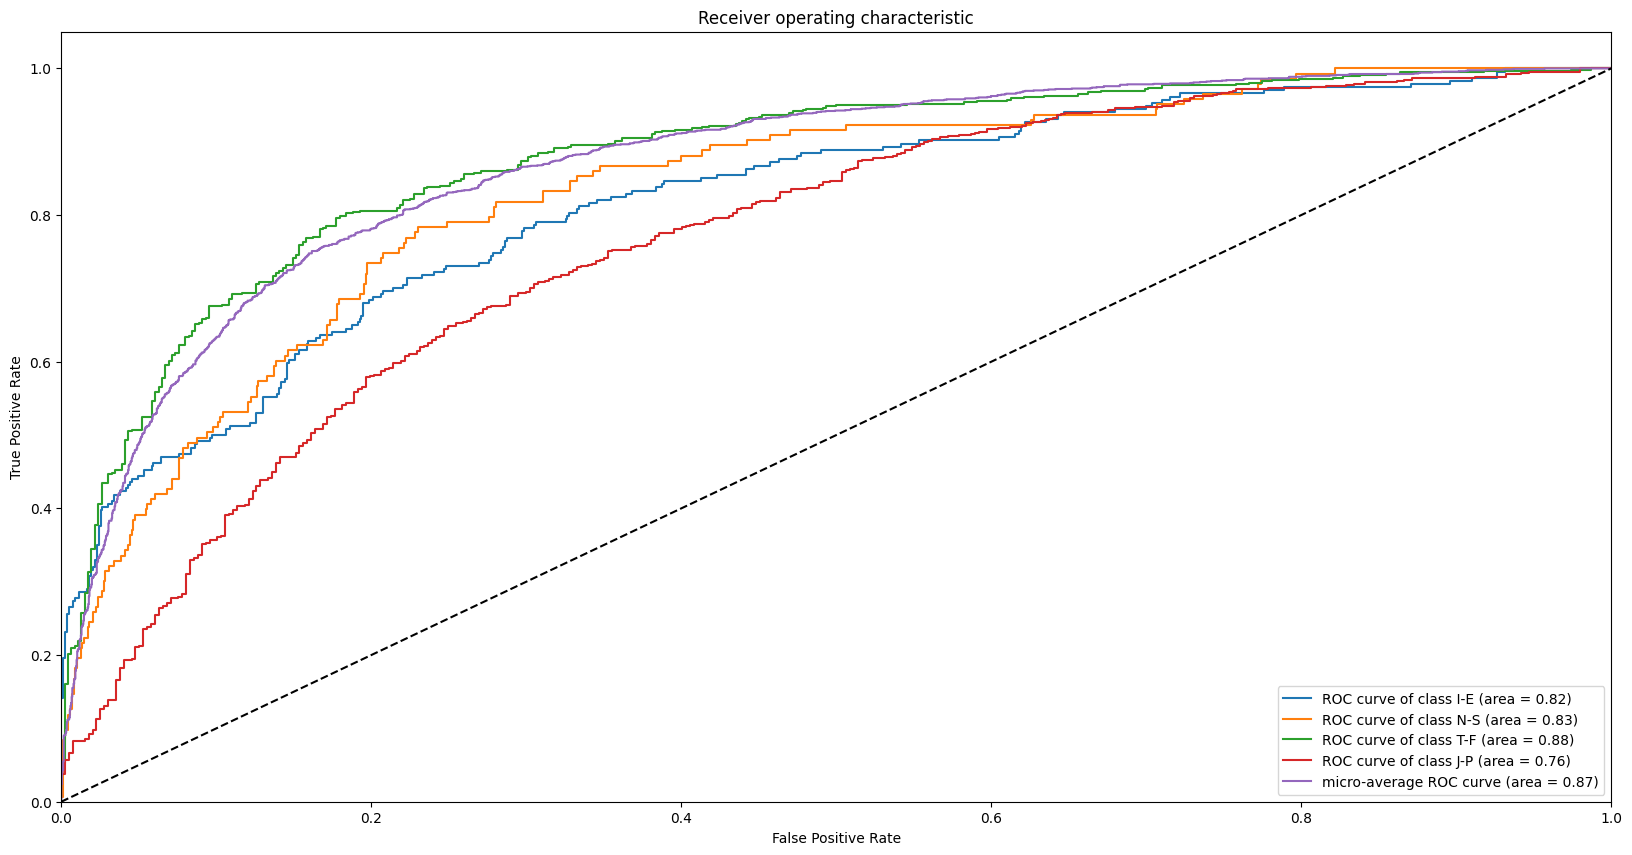

In [61]:
plot_roc_auc(y_test, flattened_list, axes)

In [62]:
model.to(device);

In [71]:
s1 = (
    "I like studying deep learning, playing football and my guitar, "
    "and I love visit foreign cities all over the world."
)
sentences = np.asarray([s1])
input_ids, token_type_ids, attention_mask = prepare_bert_input(
    sentences, MAX_SEQ_LEN, BERT_NAME
)
model.to(device)
with torch.no_grad():
    preds = (
        model(
            torch.Tensor(input_ids).long().to(device),
            torch.Tensor(token_type_ids).long().to(device),
            torch.Tensor(attention_mask).long().to(device),
        )
        .detach()
        .cpu()
        .numpy()
    )

for sentence, pred in zip(sentences, preds):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])

    print(
        "-- comment: "
        + sentence.replace("\n", "").strip()
        + "\n-- personality: "
        + str(pred_axis)
        + "\n-- scores:"
        + str(pred)
    )

-- comment: I like studying deep learning, playing football and my guitar, and I love visit foreign cities all over the world.
-- personality: ['I', 'N', 'F', 'P']
-- scores:[0.27372834 0.2675252  0.57721424 0.69123715]


# Computing part

In [15]:
model.eval()
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)


def prepare_bert_input_cuda(sentences, seq_len):
    encodings = tokenizer(
        sentences.tolist(), truncation=True, padding="max_length", max_length=seq_len
    )
    input = [
        np.array(encodings["input_ids"]),
        np.array(encodings["token_type_ids"]),
        np.array(encodings["attention_mask"]),
    ]
    return input

In [31]:
model.to(device)
MAX_SEQ_LEN, BERT_NAME = 128, "bert-base-uncased"


def get_personality(text):
    sentence = np.asarray([text])
    input_ids, token_type_ids, attention_mask = prepare_bert_input_cuda(
        sentence, MAX_SEQ_LEN
    )
    with torch.no_grad():
        preds = (
            model(
                torch.Tensor(input_ids).long().to(device),
                torch.Tensor(token_type_ids).long().to(device),
                torch.Tensor(attention_mask).long().to(device),
            )
            .detach()
            .cpu()
            .numpy()
        )
    pred_axis = []
    for sentence, pred in zip(sentences, preds):
        mask = (pred > 0.5).astype(bool)
        for i in range(len(mask)):
            if mask[i]:
                pred_axis.append(axes[i][2])
            else:
                pred_axis.append(axes[i][0])
    return {"type": pred_axis, "preds": preds[0]}

In [32]:
print(
    get_personality(
        "I like studying deep learning, playing football and my guitar, "
        "and I love visit foreign cities all over the world."
    )
)

{'type': ['I', 'N', 'F', 'P'], 'preds': array([0.27372834, 0.2675252 , 0.57721424, 0.69123715], dtype=float32)}


In [33]:
data = pd.read_csv(os.path.join(data_dir, "combined_emo_5comments_10_300.csv"))

In [ ]:
tqdm.pandas(total=data.shape[0], desc="MBTI getting", colour="yellow")
data["mbti"] = data.progress_apply(lambda row: get_personality(row.comment), axis=1)

MBTI getting:   0%|          | 0/396280 [00:00<?, ?it/s]

In [ ]:
data.to_json(
    os.path.join(data_dir, "bert_personality.json"),
    orient="records",
    indent=4,
    force_ascii=False,
)